# Imports

In [ ]:
import requests
from io import BytesIO

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
from torch import nn
import albumentations as A
from PIL import Image
import timm
from timm.scheduler.step_lr import StepLRScheduler

%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Сверточные сети

Простой случай: когда работаем с одним каналом, и создаем 1 канал

![conv](https://velog.velcdn.com/images/iissaacc/post/443d5ae0-b4b6-4203-a0bb-ed2607fe7956/convSobel.gif "conv")

- Учитывает специфику фото (корреляцию близких признаков)
- Требует значительно меньше весов для качественного результата, чем Linear

Когда получаем на вход три канала, а создаем 2

![conv](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Findiantechwarrior.com%2Fwp-content%2Fuploads%2F2022%2F05%2Fconv3.gif&f=1&nofb=1&ipt=f08cd627eac37e591c5512aa5454cde5257304899fb18b5837cacadaa9b30019&ipo=images)

- Значения с разных каналов агрегируются вместе (можно, кстати, модифицировать это поведение через параметр `groups`)

In [ ]:
in_num_channels = 3
out_num_channels = 2
width = 100
height = 150
batch_size = 1

image = torch.randn((batch_size, in_num_channels, width, height))
layer = nn.Conv2d(in_num_channels, out_num_channels, kernel_size=3)
layer(image).shape

torch.Size([1, 2, 98, 148])

Полезные параметры в nn.Conv2d:

- padding
- stride

# Стандартная архитектура сверточных нейронок

- Свертка
- Активация
- Свертка
- Активация
...
- Свертка
- Активация
- Flatten
- Несколько полносвязных слоев для выдачи финального предсказания

In [ ]:
class ConvModel(nn.Module):
    def __init__(self, num_channels: int, num_classes: int) -> None:
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(num_channels, 8, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
        )
        # Кол-во признаков на вход первому линеару можно увидеть,
        # просто запустив модель
        self.classifier_head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(433152, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.body(x)

        x = self.classifier_head(x)
        return x


model = ConvModel(num_channels=3, num_classes=10)
model(image).shape

torch.Size([1, 10])

- Стандартный подход в обучении сверточных нейронок: воспринимаем каждый канал как "признак"
- В процессе прохода по слоям делаем больше каналов, ширина-высота при этом уменьшаются
- Для более быстрого уменьшения размера признаков можно использовать `nn.MaxPool2d` или `nn.AvgPool2d` - эти слои аналогичны nn.Conv2d, только вместо умножения на ядро они берут максимальное/среднее значение

# Аугментации

- Позволяет разнообразить фото в датасете, увеличивая обобщаемость модели
- Стандартные аугментации: изменение яркости, контраста, оттенок цветов, кроп

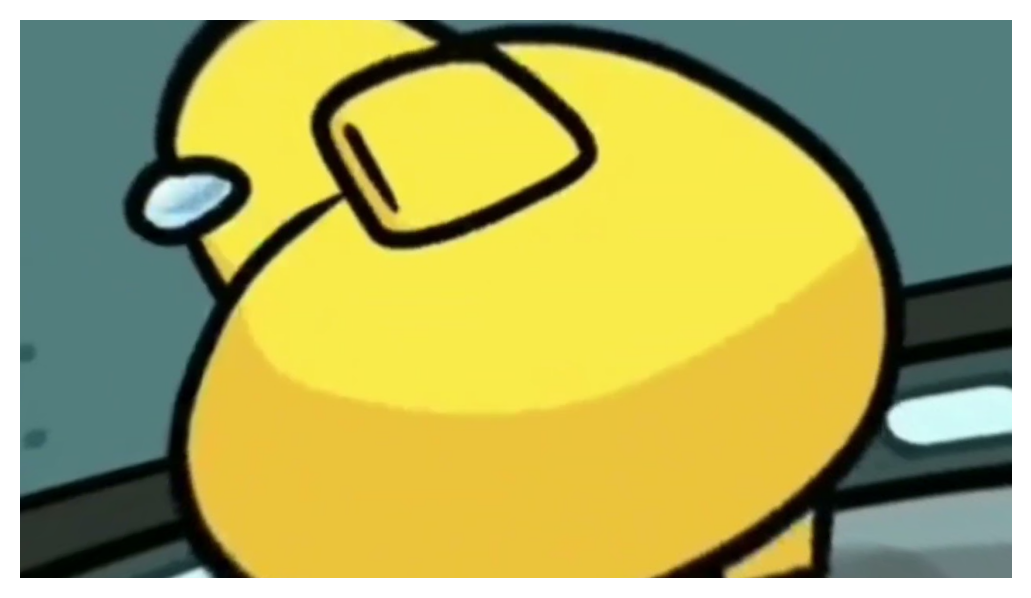

In [ ]:
response = requests.get("https://i.ytimg.com/vi/MsJ0xWKcfxI/maxresdefault.jpg")
im_pil = Image.open(BytesIO(response.content))
im = np.array(im_pil)

transform = A.Compose(
    [
        A.OpticalDistortion(distort_limit=0.5, shift_limit=0.5, p=1),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
    ]
)

plt.imshow(transform(image=im)["image"])
plt.axis("off")
plt.show()

Список аугментаций в albumentations: https://albumentations.ai/docs/api_reference/augmentations/geometric/transforms/#albumentations.augmentations.geometric.transforms.OpticalDistortion

Beware:
- При выборе аугментаций стоит учитывать, какая итоговая задача. Например, если вам нужно у вас задача классификации, в которой есть классы, зависящие от направления лево/право (левая дверь/правая дверь), то HorizontalFlip не стоит использовать
- Сверточные нейронки больше обращают внимание на текстуру, а не на форму, и если вы будете пытаться при помощи сильных аугментаций заставить нейронку обращать внимание на форму, она может это не осилить. Подробнее: https://habr.com/ru/articles/591779/

# OpenCV

Популярная библиотека для компьютерного зрения. В ней есть множество алгоритмов, связанных с модификацией фото/видео, детекцией объектов, контуров. Работает с фото в виде массивов нампай.

Два самых больных момента - ужасные описания ошибок, из них ничего не понятно. И тот факт, что cv2.imread загружает картинки в формате BGR, а не RGB.

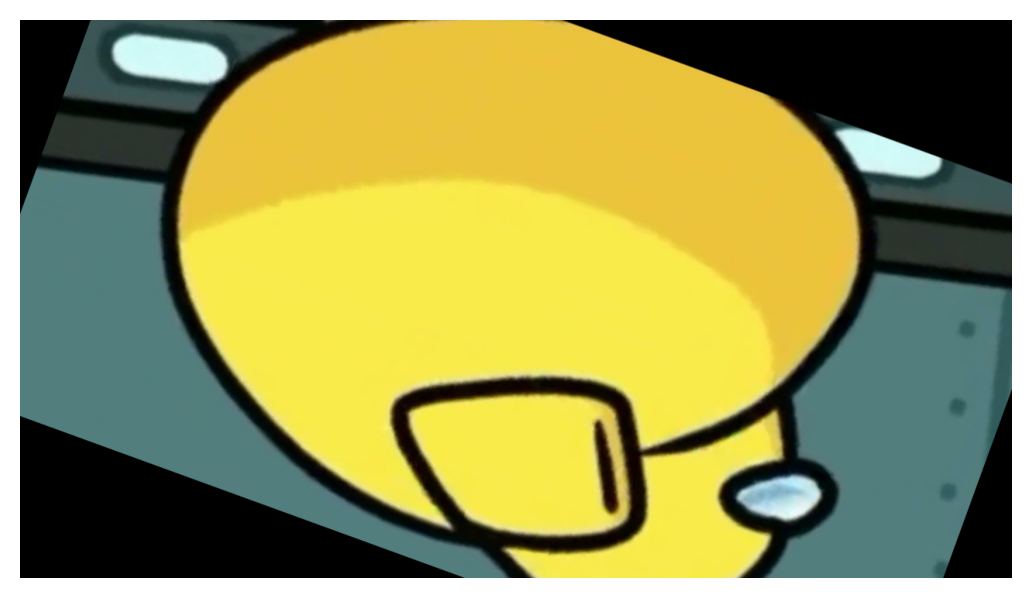

In [ ]:
(h, w, d) = im.shape
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, 160, 1.0)
plt.imshow(cv2.warpAffine(im, M, (w, h)))
plt.axis("off")
plt.show()

# Transfer learning

Transfer learning - когда берется предобученная модель, и на ее основе обучается новая модель.

Смысл предобученной модели - создать эмбеддинги, которые отражают паттерны/взаимоотношения между элементами генеральной совокупности. Далее (в случае классификации) эти эмбеддинги можно просто передать в полносвязный слой, который уже выдаст вероятности классов. При этом для дообучения этого полносвязного слоя нужно обычно не очень много данных.

In [ ]:
model = torch.hub.load("pytorch/vision:v0.10.0", "resnet18", weights="ResNet18_Weights.DEFAULT")
model

Using cache found in /Users/user/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_classes = 10
# fc - fully-connected layer
model.fc = nn.Linear(512, num_classes)

# Все слои, кроме последнего можно заморозить, чтобы было легче дообучать
# Нельзя заранее сказать, будет ли модель с заморозкой весов лучше или хуже
for name, parameter in model.named_parameters():
    if name == "fc":
        parameter.requires_grad = True
    else:
        parameter.requires_grad = False

Некоторые замечания
- Для получения качественного результата датасет, на котором ведется дообучения, должен быть похож на тот, на котором была предобучена модель (самый популярный датасет для предобучения - ImageNet)
- Если вы захотели не замораживать веса при обучении - нужно в начале делать learning rate очень маленьким, чтобы не сбить веса (этого можно добиться, например, с помощью scheduler'ов)

Удобная библиотека для дообучения CV моделей - timm

In [ ]:
# Код, аналогичный прошлым ячейкам, только без заморозки
model = timm.create_model("resnet18", pretrained=True, num_classes=num_classes)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

Еще удобные параметры в `timm.create_model`:
- `features_only` - убрать последний слой, выдавать признаки
- `in_chans` - если у вас датасет похож на imagenet, но черно-белый, можно указать `in_chans=1`

Подробнее: https://timm.fast.ai/models

## Schedulers

Они отвечают за изменение learning_rate во время обучения. Хороший scheduler для дообучения - `timm.scheduler.step_lr.StepLRScheduler`



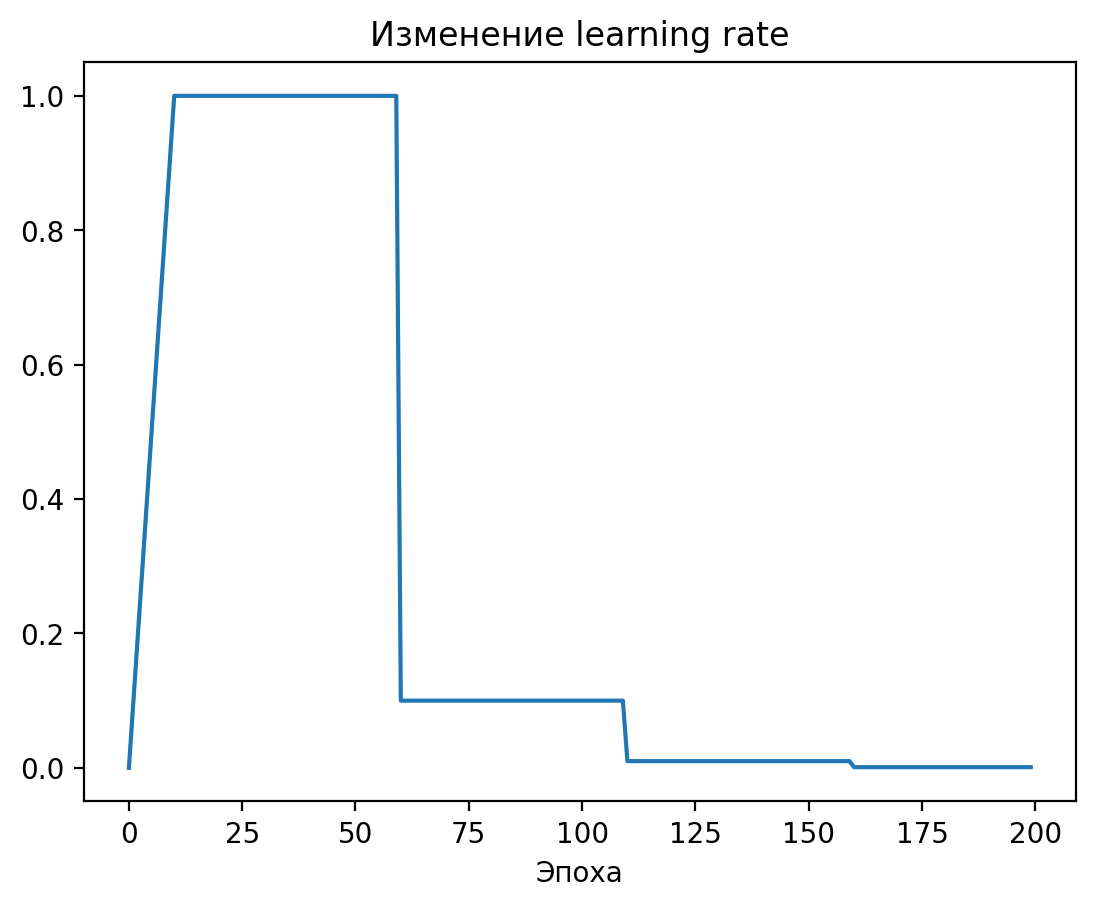

In [ ]:
def get_lr_per_epoch(scheduler, num_epoch):
    lr_per_epoch = []
    for epoch in range(num_epoch):
        lr_per_epoch.append(scheduler._get_lr(epoch))
    return lr_per_epoch


optimizer = torch.optim.SGD(model.parameters(), lr=1)
scheduler = StepLRScheduler(
    optimizer=optimizer,
    # за сколько эпох будет происходит вармап - увеличения lr с 0 до базового лр
    warmup_t=10,
    # через столько эпох lr будет умножаться на decay_rate
    decay_t=50,
    decay_rate=0.1,
)

num_epoch = 200
lr_per_epoch = get_lr_per_epoch(scheduler, num_epoch)

plt.plot(lr_per_epoch)
plt.title("Изменение learning rate")
plt.xlabel("Эпоха")
plt.show()

Для использования нужно просто вызывать scheduler.step(epoch) каждую эпоху

```python
for epoch in range(100):
    train(...)
    validate(...)
    scheduler.step()
```